# Token_Classification_NER

Задача NER – выделить спаны сущностей в тексте (спан – непрерывный фрагмент текста). Допустим, есть новостной текст, и мы хотим выделить в нем сущности (некоторый заранее зафиксированный набор — например, персоны, локации, организации, даты и так далее). 

> КРИТЕРИИ ОЦЕНИВАНИЯ ПРОЕКТА:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- использованы варианты архитектур, близкие к state of the art для данной задачи;
- произведен подбор гиперпараметров;
- использованы техники изменения learning rate (lr scheduler);
- использована адекватная задаче функция потерь;
- использованы техники регуляризации;
- корректно проведена валидация модели;
- использованы техники ensemble;
- использованы дополнительные данные;
- итоговое значение метрики качества > 0.6 (f1).

### Подготовка окружения

In [42]:
# Загрузка необходимых библиотек
!pip install transformers -q
!pip install datasets -q
!pip install seqeval -q

In [43]:
# Импорт необходимых пакетов
from urllib.request import urlretrieve
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import random
import shutil
import copy
import json
import time
import PIL
import sys
import re
import gc
import os

from tqdm import tqdm

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification, DataCollatorForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer
# huggingface's transformers library
# from transformers import RobertaForTokenClassification, RobertaTokenizer,BertTokenizerFast, BertForTokenClassification
# from transformers import BertConfig
# huggingface's datasets library
from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [44]:
#Disabling parallelism to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"

In [45]:
# Установка значений переменных и гиперпараметров
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
EPOCHS = 5
BATCH_SIZE = 16
LR_RATE = 5e-5
GRAD_ACC = 2
WD = 0.01
WARMUP = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Скачивание и загрузка датасета

In [46]:
# From https://albumentations.ai/docs/examples/pytorch_classification/
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

        
def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [47]:
dataset_directory = os.path.join("FactRuEval/")

In [48]:
# Скачивание и распаковка данных
filepath = os.path.join(dataset_directory, "FactRuEval.zip")
download_url(
    url="https://drive.google.com/uc?export=download&id=1L9FRamgoyADFt-8c1uBp3d1QYqMzmJ3E",
    filepath=filepath,
)
extract_archive(filepath)

Filepath already exists. Skipping download.


In [49]:
!head /content/FactRuEval/train.txt

" O
Если O
Миронов B-PER
занял O
столь O
оппозиционную O
позицию O
, O
то O
мне O


In [50]:
# Разделим данные на тренировочную и валидационную выборку
train_txt = os.path.join(dataset_directory, "train.txt")
val_txt = os.path.join(dataset_directory, "dev.txt")
test_txt = os.path.join(dataset_directory, "test.txt")

In [51]:
# read all lines from train
with open(train_txt,'r') as train:
    train_words = train.readlines()

# read all lines from val
with open(val_txt,'r') as val:
    val_words = val.readlines()

# read all lines from test    
with open(test_txt,'r') as test:
    test_words = test.readlines() 

### Предобработка данных

In [52]:
def get_tokens_ners(words):
    tokens, ner_tags = [],[]
    for word in words:
        if len(word.strip())>0:
            #print(word)
            token, ner = word.split()
            ner = ner.strip('\n')
            tokens.append(token)
            ner_tags.append(ner)
    return tokens, ner_tags

In [53]:
# Все используемые ner_tags
train_labels = set(get_tokens_ners(train_words)[1])
val_labels = set(get_tokens_ners(val_words)[1])
test_labels = set(get_tokens_ners(test_words)[1])

print(train_labels,'\n', val_labels,'\n', test_labels)

{'B-LOC', 'I-PER', 'B-ORG', 'I-ORG', 'O', 'B-PER', 'I-LOC'} 
 {'B-LOC', 'I-PER', 'B-ORG', 'I-ORG', 'O', 'B-PER', 'I-LOC'} 
 {'B-LOC', 'I-PER', 'B-ORG', 'I-ORG', 'O', 'B-PER', 'I-LOC'}


- O means the word doesn’t correspond to any entity.
- B-PER/I-PER means the word corresponds to the beginning of/is inside a person entity.
- B-ORG/I-ORG means the word corresponds to the beginning of/is inside an organization entity.
- B-LOC/I-LOC means the word corresponds to the beginning of/is inside a location entity.

In [54]:
# Преобразуем ner_tags в числовой формат, определим количество уникальных тегов
label2id: dict = {k: v for v, k in enumerate(train_labels)}
id2label: dict = {value: key for key, value in label2id.items()}
# train_df['Name_of_person'] = train_df['Name_of_person'].apply(lambda x: class_label_to_index[x])
NUM_CLASSES = len(train_labels)

In [55]:
label2id

{'B-LOC': 0,
 'I-PER': 1,
 'B-ORG': 2,
 'I-ORG': 3,
 'O': 4,
 'B-PER': 5,
 'I-LOC': 6}

In [56]:
text = ' '.join(get_tokens_ners(train_words)[0])
text[:300]

'" Если Миронов занял столь оппозиционную позицию , то мне представляется , что для него было бы порядочным и правильным уйти в отставку с занимаемого им поста , поста , который предоставлен ему сегодня " Единой Россией \'\' и никем больше \'\' , - заключает Исаев . Источник " Ъ \'\' в руководстве столично'

In [57]:
text = ' '.join(get_tokens_ners(val_words)[0])
text[:300]

'как акционерный коммерческий Московский муниципальный банк - Банк Москвы , контрольный пакет акций которого принадлежал правительству Москвы . Управлять ЦАО и САО вместо Алексея Александрова и Олега Митволя будут бывшие заместители Юрия Лужкова . О задержании Шакирьянова стало известно 8 февраля 201'

In [58]:
text = ' '.join(get_tokens_ners(test_words)[0])
text[:300]

'Тогда замешанные в скандале прокуроры отделались выговорами и благополучно вернулись на работу . Символичным назвал председатель РФМ , депутат Государственной думы РФ Леонид Слуцкий ( ЛДПР ) установку памятника Твардовскому в день годовщины Великой Отечественной войны . На посту гендиректора Yahoo !'

### Загрузка и обучение модели

In [59]:
model_name = "sberbank-ai/bert-base-NER-reptile-5-datasets" #https://huggingface.co/sberbank-ai/bert-base-NER-reptile-5-datasets

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True, model_max_length = 512)
model = AutoModelForTokenClassification.from_pretrained(model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sberbank-ai--bert-base-NER-reptile-5-datasets/snapshots/feb2dcd088bf24fde96b3f53f720ac148fb678ef/config.json
Model config BertConfig {
  "_name_or_path": "sberbank-ai/bert-base-NER-reptile-5-datasets",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sberbank-ai--bert-base-NER-r

In [60]:
torch.cuda.empty_cache()
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [61]:
def get_dict_tokens_ners(words):
    
    idx, tokens, ner_tags  = 0, [],[]
    dataset_json = []
    for line in words:

        line = line.strip('\n')
        if len(line.strip()) == 0:

            cur_tokens = copy.deepcopy(tokens)
            cur_ner_tags =copy.deepcopy(ner_tags)

            dict_ner = {'id': idx, 'tokens': cur_tokens,'length': len(cur_tokens), 'ner_tags_str': cur_ner_tags, 'ner_tags': [ label2id[i] for i in cur_ner_tags]}
            dataset_json.append(dict_ner)

            idx += 1
            tokens.clear()
            ner_tags.clear()
        else:
            token, ner = line.split()

            # check if ner tag not in token
            if token not in list(id2label.keys()):
                ner = ner.strip('\n')
                tokens.append(token)
                ner_tags.append(ner)
    data = {}
    data['data'] = dataset_json      
    return data

In [62]:
%%time

names = ['train', 'val', 'test']
for idx, words in enumerate([train_words, val_words, test_words]):
    print(names[idx])
    data = get_dict_tokens_ners(words)
    with open(f'{names[idx]}_data.json', 'w') as f:
        json.dump(data, f)

train
val
test
CPU times: user 1.23 s, sys: 47.3 ms, total: 1.28 s
Wall time: 1.3 s


In [63]:
tokens, ner_tags = [],[]
for word in words:
    if len(word.strip())>0:
        #print(word)
        token, ner = word.split()
        ner = ner.strip('\n')
        tokens.append(token)
        ner_tags.append(ner)
        
text = ' '.join(tokens)

In [64]:
data_files = {"train": 'train_data.json', 'val':'val_data.json', 'test':'test_data.json'}

In [65]:
load_json_dataset = load_dataset('json', data_files=data_files,field ='data')
load_json_dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-0410f17b271710d7/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 7746
    })
    val: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 2582
    })
    test: Dataset({
        features: ['id', 'tokens', 'length', 'ner_tags_str', 'ner_tags'],
        num_rows: 2582
    })
})

In [66]:
MAX_LEN = max([max(load_json_dataset['train']['length']), max(load_json_dataset['val']['length']), max(load_json_dataset['test']['length'])])
MAX_LEN

222

In [67]:
def add_encodings(example):
    """Processing the example
    
    Args:
        example (dict): The dataset example.
    
    Returns:
        dict: The dictionary containing the following updates:
            - input_ids: The list of input ids of the tokens.
            - attention_mask: The attention mask list.
            - ner_tags: The updated ner_tags.
    
    """
    # get the encodings of the tokens. The tokens are already split, that is why we must add is_split_into_words=True

    try:
        encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', max_length = MAX_LEN, is_split_into_words=True)
        
        # extend the ner_tags so that it matches the max_length of the input_ids
        labels = example['ner_tags'] + [0] * (MAX_LEN - len(example['ner_tags']))
        
        # return the encodings and the extended ner_tags
        return { **encodings, 'labels': labels }
    except Exception as ex:
        print(ex)
        #print(example['tokens'])
        return 

In [68]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [69]:
# modify/format all datasets so that they include the 'input_ids', 'attention_mask' 
# and 'labels' used to train and evaluate the model
#load_json_dataset = load_json_dataset.map(add_encodings)
tokenized_datasets = load_json_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=load_json_dataset["train"].column_names,
)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [70]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [71]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    4,    4,    4,    4,    4,    5,    6,    6,    6,    6,    6,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,  

In [72]:
# format the datasets so that we return only 'input_ids', 'attention_mask' and 'labels' 
# making it easier to train and validate the model
#load_json_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 4, -100]
[-100, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [73]:
label_names = list(label2id.keys())
label_names

['B-LOC', 'I-PER', 'B-ORG', 'I-ORG', 'O', 'B-PER', 'I-LOC']

In [74]:
labels = load_json_dataset["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['O',
 'O',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'O']

In [75]:
metric = load_metric("seqeval")

In [76]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'PER': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.9787234042553191}

In [77]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [78]:
# initialize the model and provide the 'num_labels' used to create the classification layer
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=NUM_CLASSES)

# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sberbank-ai--bert-base-NER-reptile-5-datasets/snapshots/feb2dcd088bf24fde96b3f53f720ac148fb678ef/config.json
Model config BertConfig {
  "_name_or_path": "sberbank-ai/bert-base-NER-reptile-5-datasets",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_hea

In [79]:
model.config.num_labels

7

In [80]:
args = TrainingArguments(
    "finetuned-ner",
    evaluation_strategy = "epoch",
    logging_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=LR_RATE,
    lr_scheduler_type = "cosine_with_restarts",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WD,
    gradient_accumulation_steps=GRAD_ACC,
    warmup_ratio=WARMUP,
    fp16 = True,
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [81]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 7746
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1210
  Number of trainable parameters = 108897031


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.555600,0.203225,0.789583,0.692827,0.738048,0.937220
1,0.171700,0.146870,0.866211,0.766104,0.813088,0.953904
2,0.102600,0.115747,0.863133,0.857196,0.860154,0.964402
3,0.063900,0.118166,0.838242,0.894160,0.865298,0.964336
4,0.046100,0.111448,0.876424,0.884462,0.880424,0.969207


***** Running Evaluation *****
  Num examples = 2582
  Batch size = 16
Saving model checkpoint to finetuned-ner/checkpoint-242
Configuration saved in finetuned-ner/checkpoint-242/config.json
Model weights saved in finetuned-ner/checkpoint-242/pytorch_model.bin
tokenizer config file saved in finetuned-ner/checkpoint-242/tokenizer_config.json
Special tokens file saved in finetuned-ner/checkpoint-242/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2582
  Batch size = 16
Saving model checkpoint to finetuned-ner/checkpoint-484
Configuration saved in finetuned-ner/checkpoint-484/config.json
Model weights saved in finetuned-ner/checkpoint-484/pytorch_model.bin
tokenizer config file saved in finetuned-ner/checkpoint-484/tokenizer_config.json
Special tokens file saved in finetuned-ner/checkpoint-484/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2582
  Batch size = 16
Saving model checkpoint to finetuned-ner/checkpoint-726
Configuration saved in 

TrainOutput(global_step=1210, training_loss=0.1880013733855949, metrics={'train_runtime': 853.8792, 'train_samples_per_second': 45.358, 'train_steps_per_second': 1.417, 'total_flos': 4934032474798416.0, 'train_loss': 0.1880013733855949, 'epoch': 5.0})

In [82]:
trainer.save_model('./ru-finetuned-NER')

Saving model checkpoint to ./ru-finetuned-NER
Configuration saved in ./ru-finetuned-NER/config.json
Model weights saved in ./ru-finetuned-NER/pytorch_model.bin
tokenizer config file saved in ./ru-finetuned-NER/tokenizer_config.json
Special tokens file saved in ./ru-finetuned-NER/special_tokens_map.json


In [83]:
test_data = torch.utils.data.DataLoader(tokenized_datasets['test'], batch_size=16)

In [84]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

***** Running Prediction *****
  Num examples = 2582
  Batch size = 16


{'LOC': {'precision': 0.9129865881583251,
  'recall': 0.9077160744775998,
  'f1': 0.9103437028580746,
  'number': 12299},
 'ORG': {'precision': 0.8591168996188056,
  'recall': 0.8778469028942386,
  'f1': 0.8683809167045727,
  'number': 18485},
 'PER': {'precision': 0.945263754963131,
  'recall': 0.962738301559792,
  'f1': 0.9539210074413279,
  'number': 3462},
 'overall_precision': 0.8869002944402749,
 'overall_recall': 0.8971558722186532,
 'overall_f1': 0.8919986064336314,
 'overall_accuracy': 0.9713036184998802}

In [85]:
confusion = torch.zeros(NUM_CLASSES, NUM_CLASSES)
for true_values, pred_values in zip(true_predictions, true_labels):
    for true, pred in zip(true_values, pred_values):
        true_id = label2id[true]
        pred_id = label2id[pred]
        confusion[true_id][pred_id] += 1

In [86]:
for i in range(NUM_CLASSES):
    confusion[i] = confusion[i] / confusion[i].sum()

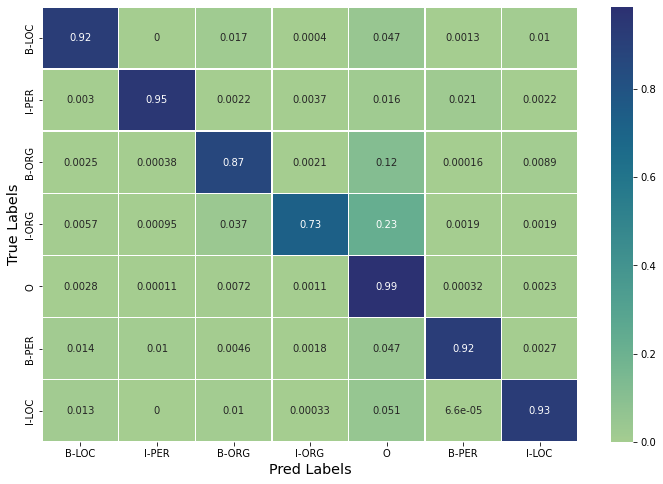

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="whitegrid", palette="pastel")
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(confusion.numpy(), cmap="crest", annot=True, linewidths=0.5, ax=ax)

# get the labels
labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

# set the x ticks
ax.set_xticklabels(labels)

# set the y ticks
ax.set_yticklabels(labels)
plt.show()